# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Лоскутов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = - \sum_j{\frac{y^{(j)}x_i^{(j)}}{1 + e^{y\langle w, x^{(j)} \rangle}}} + \frac{2}{C}w_i $$

## Имплементация (5 баллов)

In [308]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=32):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        X = np.hstack((np.ones((X.shape[0], 1)), X ))
        y = (y-0.5)*2
        self.w = np.random.random(X.shape[1])
        
        self.errors = np.empty(self.max_epoch)
        
        for epoch in xrange(self.max_epoch):
            size = X.shape[0]
            inds = np.random.permutation(np.arange(size))
            Xb = np.array([X[inds[i:i + self.batch_size]] for i in xrange(0, size, self.batch_size)])
            yb = np.array([y[inds[i:i + self.batch_size]] for i in xrange(0, size, self.batch_size)])

            for i in xrange(Xb.shape[0]):
                margin = np.array(yb[i]*Xb[i].dot(self.w))
                with np.errstate(over='ignore'):
                    grad = - (Xb[i].T).dot(yb[i]/(1 + np.e**margin)) + 2./self.C*self.w   
                self.w = self.w - self.alpha / (1 + epoch) * grad 
            with np.errstate(over='ignore'):
                self.errors[epoch] = np.sum(np.log(1 + np.e**(-y * X.dot(self.w)))) 
            
        return self
    
    def get_errors_epoch(self):
        return self.errors
    
    def sigmoid(self, x):
        return 1./(1 + np.e**(-x))
    
    def get_weights(self):
        return self.w
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_hat = np.sign(X.dot(self.w))/2+0.5
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_hat_proba = np.hstack(((self.sigmoid(X.dot(self.w)), self.sigmoid(-X.dot(self.w)))))
        
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

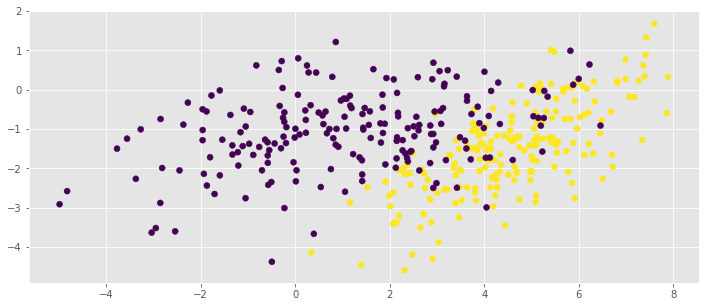

In [281]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [309]:
model = MySGDClassifier(max_epoch=40, C=100, batch_size=32, alpha=0.04)
model.fit(X, y)
print model.get_weights()

[-3.53397773  0.84510461 -0.8322618 ]


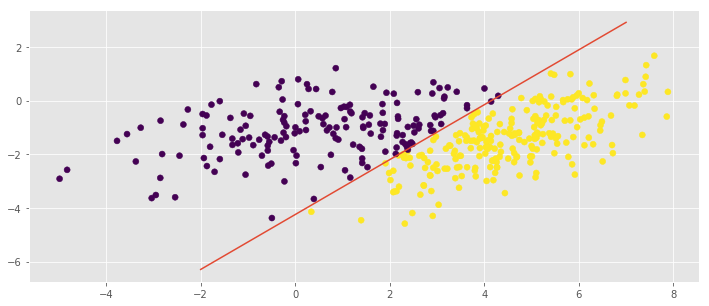

In [310]:
Y = model.predict(X)
plt.scatter(X[:,0], X[:,1], c=Y)
x = np.arange(-2, 8, 1)
y = -w[1]/w[2]*x - w[0]/w[2]
plt.plot(x, y)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [105]:
from sklearn.datasets import make_classification

In [255]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

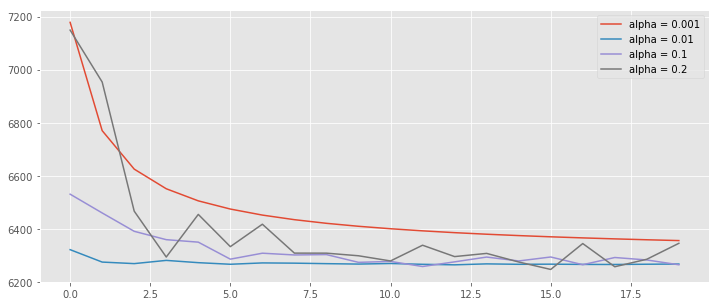

In [262]:
## Your Code Here
alphas = [0.001, 0.01, 0.1, 0.2]
max_epoch = 20
size = len(alphas)
err = np.empty((size, max_epoch))
for i, x in enumerate(alphas):
    model_convergence = MySGDClassifier(alpha=x, C=100, max_epoch=max_epoch)
    model_convergence.fit(X, y)
    err[i] = model_convergence.get_errors_epoch()
for i in xrange(size):
    plt.plot(range(max_epoch), err[i], label='alpha = ' + str(alphas[i]))
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

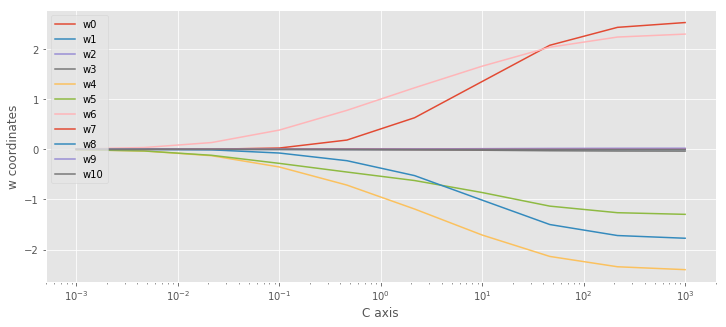

In [135]:
## Your Code Here
w = np.empty((10,11))
logs = np.logspace(3, -3, 10)
for i, C in enumerate(logs):
    model_reg = MySGDClassifier(C=C, alpha=0.001, max_epoch=40)
    model_reg.fit(X, y)
    w[i] = model_reg.get_weights()

for i in xrange(11):
    plt.plot(logs, w[:, i], label="w"+str(i))
plt.ylabel("w coordinates")
plt.xlabel("C axis")
plt.legend(loc=2)
plt.xscale('log')

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [250]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = 'trainingData_tabular/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [251]:
df_data.shape

(500000, 44)

In [252]:
df_data.head()

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
gamestate_id,,,,,,,,,,,,,,,,,,,,,
4687346,1,14,0,0,798,5,0,0,10,10,...,20,23,4,0,1,5,0,20,22,17
3270826,1,7,0,0,754,22,0,0,6,6,...,16,17,3,2,2,7,0,17,26,20
3189487,1,5,3,0,612,29,0,0,4,1,...,0,0,5,0,0,5,2,26,28,27
4098946,1,8,0,0,390,26,0,0,7,7,...,2,2,7,1,1,9,9,36,44,36
2661127,0,13,0,0,25,30,0,0,10,1,...,7,7,4,0,0,4,4,13,13,14


In [253]:
df_data.T.head()

gamestate_id,4687346,3270826,3189487,4098946,2661127,2993360,4378268,3774658,3956442,2958739,...,2135543,4652905,3851901,4928551,1547081,4649714,1089131,3457659,3503888,2886512
decision,1,1,1,1,0,0,0,1,1,1,...,1,1,0,1,1,1,0,1,0,0
turn,14,7,5,8,13,13,9,2,12,10,...,6,6,6,6,8,6,8,23,6,8
opponent_armor,0,0,3,0,0,0,0,0,2,0,...,0,1,1,0,6,0,2,0,0,0
opponent_attack,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,1
opponent_hero_card_id,798,754,612,390,25,612,612,390,1235,1235,...,25,612,1235,798,1235,754,1235,798,25,754


#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [142]:
## Youd Code Here
print np.sort(df_data.player_hero_card_id.unique())
print np.sort(df_data.opponent_hero_card_id.unique())

[  25  326  390  494  612  754  798  981 1235]
[  25  326  390  494  612  754  798  981 1235]


In [143]:
df_data = pd.concat([
                     df_data,
                     pd.get_dummies(df_data.player_hero_card_id, prefix="player")
                    ], axis=1)
df_data = pd.concat([
                     df_data,
                     pd.get_dummies(df_data.opponent_hero_card_id, prefix="opponent")
                    ], axis=1)
df_data.T.tail(18)

gamestate_id,4687346,3270826,3189487,4098946,2661127,2993360,4378268,3774658,3956442,2958739,...,2135543,4652905,3851901,4928551,1547081,4649714,1089131,3457659,3503888,2886512
player_25,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
player_326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
player_390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
player_494,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
player_612,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
player_754,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
player_798,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
player_981,1,0,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
player_1235,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
opponent_25,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [230]:
## Youd Code Here
y_train = np.array(df_data.decision.as_matrix())
X_train = df_data.drop(['decision'], axis=1).as_matrix()

In [236]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [242]:
model = []
for i in [1, 10, 100]:
    for j in [0.001, 0.05, 0.1, 0.2]:
        model.append(Pipeline([
                                ('std_sc', StandardScaler()),
                                ('sgd', MySGDClassifier(max_epoch=20, C=i, alpha=j))
                              ]))

In [247]:
best_model = model[0]
print "Start fit model #0"
model[0].fit(X_train, y_train)
best_roc_auc = roc_auc_score(model[0].predict(X_train), y_train)
for i in xrange(1, 12):
    model[i].fit(X_train, y_train)
    tmp_roc_auc = roc_auc_score(model[i].predict(X_train), y_train)
    print "model #" + str(i) + " has ROC AUC: " + str(tmp_roc_auc)
    if (tmp_roc_auc > best_roc_auc):
        best_roc_auc = tmp_roc_auc
        best_model = model[i]
print "Best ROC AUC on X_train is " + str(best_roc_auc)

Start fit model #0
model #1 has ROC AUC: 0.692905731352
model #2 has ROC AUC: 0.682327955712
model #3 has ROC AUC: 0.653078075712
model #4 has ROC AUC: 0.700462258818
model #5 has ROC AUC: 0.694006213954
model #6 has ROC AUC: 0.690500222522
model #7 has ROC AUC: 0.68460188857
model #8 has ROC AUC: 0.700348814211
model #9 has ROC AUC: 0.694943753042
model #10 has ROC AUC: 0.684902595264
model #11 has ROC AUC: 0.682178630158
Best ROC AUC on X_train is 0.700462258818


## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [248]:
## Youd Code Here
filepath = 'trainingData_tabular/trainingData_tabular_chunk2.csv'
df_data_test = pd.read_csv(filepath, sep=',')
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')
df_data_test = pd.concat([
                          df_data_test,
                          pd.get_dummies(df_data_test.player_hero_card_id, prefix="player")
                         ], axis=1)
df_data_test = pd.concat([
                          df_data_test, 
                          pd.get_dummies(df_data_test.opponent_hero_card_id, prefix="opponent")
                         ], axis=1)
y_test = df_data_test.decision.as_matrix()
X_test = df_data_test.drop(['decision'], axis=1).as_matrix()

In [249]:
print roc_auc_score(best_model.predict(X_test), y_test)

0.700799609212
